In [ ]:
# Install required packages
!pip install torch torchvision numpy matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os


In [ ]:
# Helper function to denormalize images
def denorm(image_tensor):
    image_tensor = (image_tensor + 1) / 2
    return image_tensor.clamp(0, 1)

# Helper function to save images
def save_sample_image(image_tensor, path):
    save_image(denorm(image_tensor), path)


In [ ]:
# Dataset class for single images
class SingleImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform
        self.image = Image.open(image_path).convert('RGB')

    def __len__(self):
        return 1  # Only one image

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.image)
        else:
            image = self.image
        return image

# Define image transformations with fixed size
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to fixed size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize across 3 channels (RGB)
])

# Load single images
dataset_A = SingleImageDataset('/content/strawberry.jpeg', transform=transform)
dataset_B = SingleImageDataset('/content/banana.jpeg', transform=transform)

# Create data loaders
dataloader_A = torch.utils.data.DataLoader(dataset_A, batch_size=1, shuffle=False)
dataloader_B = torch.utils.data.DataLoader(dataset_B, batch_size=1, shuffle=False)


In [ ]:
# Define a simple generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define a simple discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# Define the loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

# Function to initialize model weights
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)

# Initialize models
netG_A2B = Generator().apply(init_weights).cuda()
netG_B2A = Generator().apply(init_weights).cuda()
netD_A = Discriminator().apply(init_weights).cuda()
netD_B = Discriminator().apply(init_weights).cuda()

# Optimizers
optimizer_G = optim.Adam(list(netG_A2B.parameters()) + list(netG_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
# Training loop
for epoch in range(200):  # For simplicity, let's use 200 epochs
    for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
        real_A = data_A.cuda()
        real_B = data_B.cuda()

        # Train Generators
        optimizer_G.zero_grad()

        # Generate fake images
        fake_B = netG_A2B(real_A)
        fake_A = netG_B2A(real_B)

        # Reconstruct images
        recov_A = netG_B2A(fake_B)
        recov_B = netG_A2B(fake_A)

        # Calculate GAN loss for generators
        loss_GAN_A2B = criterion_GAN(netD_B(fake_B), torch.ones_like(netD_B(fake_B)).cuda())
        loss_GAN_B2A = criterion_GAN(netD_A(fake_A), torch.ones_like(netD_A(fake_A)).cuda())

        # Calculate cycle consistency loss
        loss_cycle_A = criterion_cycle(recov_A, real_A) * 10.0
        loss_cycle_B = criterion_cycle(recov_B, real_B) * 10.0

        # Total generator loss
        loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B
        loss_G.backward()
        optimizer_G.step()

        # Train Discriminators
        optimizer_D_A.zero_grad()

        # Discriminator loss for real and fake images in domain A
        loss_D_A_real = criterion_GAN(netD_A(real_A), torch.ones_like(netD_A(real_A)).cuda())
        loss_D_A_fake = criterion_GAN(netD_A(fake_A.detach()), torch.zeros_like(netD_A(fake_A)).cuda())

        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()

        # Discriminator loss for real and fake images in domain B
        loss_D_B_real = criterion_GAN(netD_B(real_B), torch.ones_like(netD_B(real_B)).cuda())
        loss_D_B_fake = criterion_GAN(netD_B(fake_B.detach()), torch.zeros_like(netD_B(fake_B)).cuda())

        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # Print the losses every 100 iterations
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{200}] Batch [{i}/{len(dataloader_A)}] \
                  Loss_G: {loss_G.item():.4f} Loss_D_A: {loss_D_A.item():.4f} Loss_D_B: {loss_D_B.item():.4f}")


Epoch [0/200] Batch [0/1]                   Loss_G: 17.9641 Loss_D_A: 0.4701 Loss_D_B: 0.5914
Epoch [1/200] Batch [0/1]                   Loss_G: 17.4698 Loss_D_A: 0.2924 Loss_D_B: 0.4027
Epoch [2/200] Batch [0/1]                   Loss_G: 17.0187 Loss_D_A: 0.1631 Loss_D_B: 0.2600
Epoch [3/200] Batch [0/1]                   Loss_G: 16.5822 Loss_D_A: 0.1043 Loss_D_B: 0.1464
Epoch [4/200] Batch [0/1]                   Loss_G: 16.2605 Loss_D_A: 0.1073 Loss_D_B: 0.0921
Epoch [5/200] Batch [0/1]                   Loss_G: 16.1427 Loss_D_A: 0.0808 Loss_D_B: 0.0885
Epoch [6/200] Batch [0/1]                   Loss_G: 16.0486 Loss_D_A: 0.0708 Loss_D_B: 0.0690
Epoch [7/200] Batch [0/1]                   Loss_G: 15.5173 Loss_D_A: 0.0819 Loss_D_B: 0.0703
Epoch [8/200] Batch [0/1]                   Loss_G: 13.4690 Loss_D_A: 0.1313 Loss_D_B: 0.1138
Epoch [9/200] Batch [0/1]                   Loss_G: 9.4262 Loss_D_A: 0.1862 Loss_D_B: 0.2101
Epoch [10/200] Batch [0/1]                   Loss_G: 9.7482 L

In [ ]:
import os

# Create 'results' directory if it doesn't exist
os.makedirs('results', exist_ok=True)
#Evaluate the model
with torch.no_grad():
    for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
        real_A = data_A[0].cuda()
        real_B = data_B[0].cuda()

        fake_B = netG_A2B(real_A)
        fake_A = netG_B2A(real_B)

        save_sample_image(real_A, f'results/real_A_{i}.png')
        save_sample_image(real_B, f'results/real_B_{i}.png')
        save_sample_image(fake_B, f'results/fake_B_{i}.png')
        save_sample_image(fake_A, f'results/fake_A_{i}.png')

        if i == 9:
            break


In [ ]:
# Save models
torch.save(netG_A2B.state_dict(), 'netG_A2B.pth')
torch.save(netG_B2A.state_dict(), 'netG_B2A.pth')
torch.save(netD_A.state_dict(), 'netD_A.pth')
torch.save(netD_B.state_dict(), 'netD_B.pth')

# Load models
netG_A2B.load_state_dict(torch.load('netG_A2B.pth'))
netG_B2A.load_state_dict(torch.load('netG_B2A.pth'))
netD_A.load_state_dict(torch.load('netD_A.pth'))
netD_B.load_state_dict(torch.load('netD_B.pth'))


<All keys matched successfully>

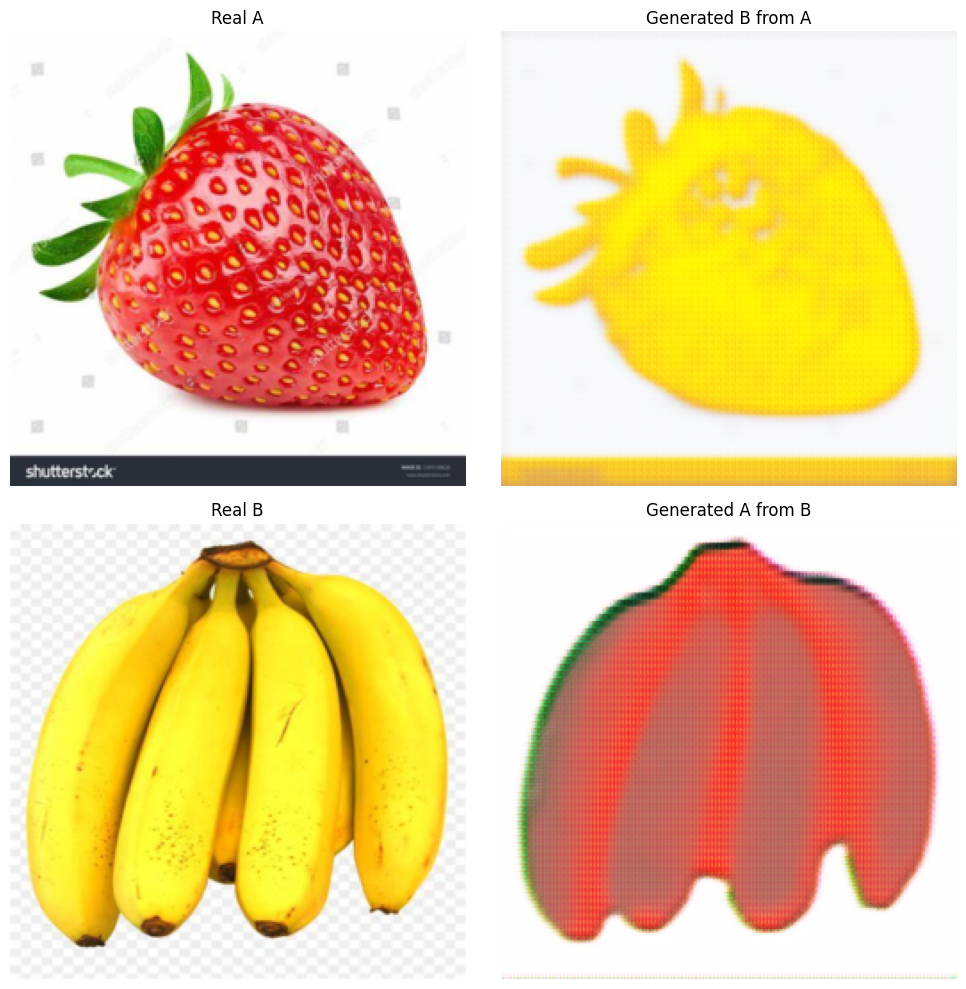

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.utils import save_image
import os

# Define visualization function
def visualize_images(real_A_path, real_B_path, fake_A_path, fake_B_path):
    # Load images
    real_A = Image.open(real_A_path)
    real_B = Image.open(real_B_path)
    fake_A = Image.open(fake_A_path)
    fake_B = Image.open(fake_B_path)

    # Display images using matplotlib
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].imshow(real_A)
    axes[0, 0].set_title('Real A')

    axes[0, 1].imshow(fake_B)
    axes[0, 1].set_title('Generated B from A')

    axes[1, 0].imshow(real_B)
    axes[1, 0].set_title('Real B')

    axes[1, 1].imshow(fake_A)
    axes[1, 1].set_title('Generated A from B')

    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have trained and saved your models and results are saved in 'results' directory
# Example usage at the end of your CycleGAN script
if __name__ == "__main__":
    # Paths to images for visualization
    real_A_path = 'results/real_A_0.png'
    real_B_path = 'results/real_B_0.png'
    fake_A_path = 'results/fake_A_0.png'
    fake_B_path = 'results/fake_B_0.png'

    # Visualize images
    visualize_images(real_A_path, real_B_path, fake_A_path, fake_B_path)
